In [1]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine


from f1tenth_sim.data_tools.general_plotting.plot_trajectory_analysis import plot_trajectory_analysis
from f1tenth_sim.data_tools.general_plotting.plot_raceline_tracking import plot_raceline_tracking

from f1tenth_sim.run_scripts.run_functions import *
import numpy as np


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## Training Graphs

In [2]:

seeds = [12, 13, 14]
rewards = ["Progress", "CTH", "TAL"]
train_maps = ["mco", "gbr", "esp", "aut"]

total_training_steps = 50000
resampled_xs = np.linspace(0, total_training_steps, 1000)

training_data = {}
for train_map in train_maps:
    for seed in seeds:
        for reward in rewards:
            test_id = f"TD3_{reward}_{seed}_{train_map}"

            root_path = f"Logs/EndToEnd/RawData_{test_id}/"
            results = pd.read_csv(root_path + f"TrainingData_{test_id}.csv")
            steps = results["Steps"]
            progresses = results["Progress"]*100

            resampled_progress = np.interp(resampled_xs, steps, progresses)
            training_data[test_id] = resampled_progress



In [3]:
avg_training_data = {}
for train_map in train_maps:
    for reward in rewards:
        temp_data = []
        for seed in seeds:
            test_id = f"TD3_{reward}_{seed}_{train_map}"
            temp_data.append(training_data[test_id])
        avg_training_data[f"{reward}_{train_map}"] = np.mean(temp_data, axis=0)

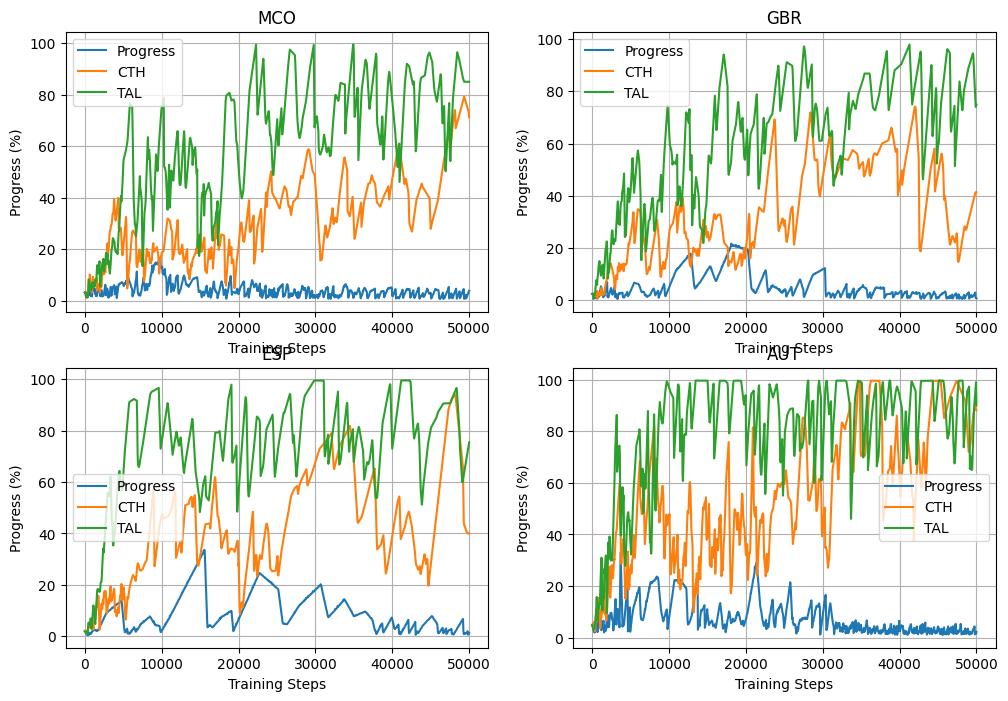

In [6]:

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, train_map in enumerate(train_maps):
    for j, reward in enumerate(rewards):
        ax[int(i/2), i%2].plot(resampled_xs, avg_training_data[f"{reward}_{train_map}"], label=reward, color=colors[j])

    ax[int(i/2), i%2].set_title(f"{train_map.upper()}")
    ax[int(i/2), i%2].set_xlabel("Training Steps")
    ax[int(i/2), i%2].set_ylabel("Progress (%)")
    ax[int(i/2), i%2].legend()
    ax[int(i/2), i%2].grid()
